In [148]:
# importing required libraries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
import warnings
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Winner prediction model 


For our final model we want to achieve a more precise prediction. We create two classes. One is for the final position 1, the other is for all other finishing positions.
For the training set we take data from 2012 until 2018. We only take data of this time frame because we don't have any tyre data for the previous years.

In [149]:
# import the data frame

ml_dataframe_df = pd.read_csv("data/finally_a_final_df.csv")

# rename columns
ml_dataframe_df.columns = ml_dataframe_df.columns.str.replace('_x', '')



In [150]:
ml_dataframe_df.columns

Index(['Unnamed: 0', 'raceId', 'year', 'circuitId', 'weather_cloudy',
       'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet',
       'driverId', 'Total Laps Full Wet', 'Total Laps Hard New',
       'Total Laps Hard Used', 'Total Laps Hyper Soft',
       'Total Laps Intermediate New', 'Total Laps Intermediate Used',
       'Total Laps Medium New', 'Total Laps Medium Used',
       'Total Laps Soft New', 'Total Laps Soft Used',
       'Total Laps Supersoft New', 'Total Laps Supersoft Used',
       'Total Laps Ultrasoft New', 'Total Laps Ultrasoft Used',
       'Total Laps Wet New', 'circuitRef', 'resultId', 'constructorId', 'grid',
       'positionOrder', 'points', 'pit_stop_1_lap', 'pit_stop_1_milliseconds',
       'pit_stop_2_lap', 'pit_stop_2_milliseconds', 'pit_stop_3_lap',
       'pit_stop_3_milliseconds', 'pit_stop_4_lap', 'pit_stop_4_milliseconds',
       'pit_stop_5_lap', 'pit_stop_5_milliseconds', 'pit_stop_6_lap',
       'pit_stop_6_milliseconds'],
      dtype='obje

### Features 

For our baseline model we only had a look at the starting position (grid). For our next model we want to also include the average laps driven with each tyre type, categorized weather information and pit stop information.
Weather categories excluded, we consider the other information as future data. Therefore we will deal with this issue with feature engineering.

In [151]:
# Filter out features we want to work with
columns_to_keep = ['raceId', 'year', 'circuitId', 'weather_cloudy',
       'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet',
       'driverId', 'Total Laps Full Wet', 'Total Laps Hard New',
       'Total Laps Hard Used', 'Total Laps Hyper Soft',
       'Total Laps Intermediate New', 'Total Laps Intermediate Used',
       'Total Laps Medium New', 'Total Laps Medium Used',
       'Total Laps Soft New', 'Total Laps Soft Used',
       'Total Laps Supersoft New', 'Total Laps Supersoft Used',
       'Total Laps Ultrasoft New', 'Total Laps Ultrasoft Used',
       'Total Laps Wet New', 'constructorId', 'grid',
       'positionOrder', 'pit_stop_1_lap', 'pit_stop_1_milliseconds',
       'pit_stop_2_lap', 'pit_stop_2_milliseconds', 'pit_stop_3_lap',
       'pit_stop_3_milliseconds', 'pit_stop_4_lap', 'pit_stop_4_milliseconds',
       'pit_stop_5_lap', 'pit_stop_5_milliseconds', 'pit_stop_6_lap',
       'pit_stop_6_milliseconds']


new_merged_df = ml_dataframe_df[columns_to_keep].copy()


print(new_merged_df)


      raceId  year  circuitId  weather_cloudy  weather_cold  weather_dry   
0        860  2012          1           False         False        False  \
1        880  2013          1           False         False        False   
2        926  2015          1            True         False        False   
3        948  2016          1            True         False        False   
4        969  2017          1            True         False        False   
5        989  2018          1           False         False        False   
6       1010  2019          1           False         False        False   
7       1076  2022          1            True         False        False   
8        861  2012          2           False         False        False   
9        881  2013          2           False         False        False   
10       901  2014          2           False         False         True   
11       927  2015          2           False         False        False   
12       963

#### Create a new column 'Class' 

We want to create a column for the classification task based on the condition: 
class 1 = final position 1
class 0 = all other positions

This leads to an uneven class distribution. 

In [152]:

#new_merged_df['Class'] = new_merged_df['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Create a new column 'Class' based on the updated condition
new_merged_df['Class'] = new_merged_df['positionOrder'].apply(lambda x: 1 if x == 1 else 0)

# Split the DataFrame into features (X) and target (y)
X = new_merged_df.drop(columns=['positionOrder', 'Class'])  # Assuming other columns are features
y = new_merged_df['Class']



In [153]:
# Calculate class imbalance before oversampling for the 'Class' column
class_distribution_before_oversampling = new_merged_df['Class'].value_counts(normalize=True)

# Print the class imbalance
print("Class Imbalance Before Oversampling:")
print(class_distribution_before_oversampling)

# Check the new class distribution in the unbalanced DataFrame
balanced_class_distribution = new_merged_df['Class'].value_counts()
print("Balanced Class Distribution:")
print(balanced_class_distribution)


Class Imbalance Before Oversampling:
Class
0    0.950747
1    0.049253
Name: proportion, dtype: float64
Balanced Class Distribution:
Class
0    3436
1     178
Name: count, dtype: int64


In [154]:
# Let's calculate the CIR

# Count the number of samples in each class
class_counts = new_merged_df['Class'].value_counts()

# Calculate the CIR
CIR = class_counts[0] / class_counts[1]

print("Class Inequality Ratio (CIR):", CIR)


Class Inequality Ratio (CIR): 19.303370786516854


##### Oversampling

As we can see above the class distribution is very unbalanced. To counter this we will use oversampling of our minority class 1 to get a more balanced data set to train out model on. Oversampling should reduce inaccuracy by giving our model the possibility to evenly train both classes and predict both precisely.

In [155]:
# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fit and transform the data to oversample the minority class
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new balanced DataFrame
balanced_df = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution in the balanced DataFrame
balanced_class_distribution = balanced_df['Class'].value_counts()
print("Balanced Class Distribution:")
print(balanced_class_distribution)

Balanced Class Distribution:
Class
0    3436
1    3436
Name: count, dtype: int64


In [156]:
balanced_df.to_csv("data/balanced_df.csv")

In [157]:
balanced_df.columns

Index(['raceId', 'year', 'circuitId', 'weather_cloudy', 'weather_cold',
       'weather_dry', 'weather_warm', 'weather_wet', 'driverId',
       'Total Laps Full Wet', 'Total Laps Hard New', 'Total Laps Hard Used',
       'Total Laps Hyper Soft', 'Total Laps Intermediate New',
       'Total Laps Intermediate Used', 'Total Laps Medium New',
       'Total Laps Medium Used', 'Total Laps Soft New', 'Total Laps Soft Used',
       'Total Laps Supersoft New', 'Total Laps Supersoft Used',
       'Total Laps Ultrasoft New', 'Total Laps Ultrasoft Used',
       'Total Laps Wet New', 'constructorId', 'grid', 'pit_stop_1_lap',
       'pit_stop_1_milliseconds', 'pit_stop_2_lap', 'pit_stop_2_milliseconds',
       'pit_stop_3_lap', 'pit_stop_3_milliseconds', 'pit_stop_4_lap',
       'pit_stop_4_milliseconds', 'pit_stop_5_lap', 'pit_stop_5_milliseconds',
       'pit_stop_6_lap', 'pit_stop_6_milliseconds', 'Class'],
      dtype='object')

In [158]:
count_unique = balanced_df[balanced_df["year"] == 2019].nunique()
count_unique.head(30)

raceId                           21
year                              1
circuitId                        21
weather_cloudy                    2
weather_cold                      1
weather_dry                       1
weather_warm                      2
weather_wet                       2
driverId                         18
Total Laps Full Wet               1
Total Laps Hard New              57
Total Laps Hard Used              8
Total Laps Hyper Soft             1
Total Laps Intermediate New      11
Total Laps Intermediate Used      1
Total Laps Medium New            53
Total Laps Medium Used           29
Total Laps Soft New              36
Total Laps Soft Used             41
Total Laps Supersoft New          1
Total Laps Supersoft Used         1
Total Laps Ultrasoft New          1
Total Laps Ultrasoft Used         1
Total Laps Wet New                5
constructorId                    10
grid                             21
pit_stop_1_lap                   46
pit_stop_1_milliseconds     

### Feature Engineering

Because we can't know the values for the average laps that were driven with certain tyre types and the exact times and of the pit stops or the laps thy were taken in, we calculate the median values of our training data and assume that our test data will have comparable values in those columns. 
To be more precise we calculate the median values for the different circuits. Especially for the pit stops this es essential because the pit lane, the way after the pit that leads back on the circuit, has different lengths on different circuits that directly influence the pit stop duration (time on the pit lane counts, too). 
We decided to take median values to counter the effect of outliers. In some cases there were very long pit stops or even additional pit stops because of collisions or weather conditions.

Imputation: 
We decided to fill in missing values with median values to preserve the data integrity and avoid biased/ inaccurate results.

## Random Forest Model

Let's try training a Random Forest classifier for our classification task. Random Forest is an ensemble learning method that combines multiple decision trees to improve predictive performance and reduce overfitting. 

In [159]:
new_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   raceId                        3614 non-null   int64  
 1   year                          3614 non-null   int64  
 2   circuitId                     3614 non-null   int64  
 3   weather_cloudy                3614 non-null   bool   
 4   weather_cold                  3614 non-null   bool   
 5   weather_dry                   3614 non-null   bool   
 6   weather_warm                  3614 non-null   bool   
 7   weather_wet                   3614 non-null   bool   
 8   driverId                      3614 non-null   float64
 9   Total Laps Full Wet           3614 non-null   int64  
 10  Total Laps Hard New           3614 non-null   int64  
 11  Total Laps Hard Used          3614 non-null   int64  
 12  Total Laps Hyper Soft         3614 non-null   int64  
 13  Tot

In [160]:
# oversampling only for the training data! check

# Columns for which we want to calculate the median
columns_to_fit_median = [ 'weather_cloudy',
       'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet',
       'Total Laps Full Wet', 'Total Laps Hard New',
       'Total Laps Hard Used', 'Total Laps Hyper Soft',
       'Total Laps Intermediate New', 'Total Laps Intermediate Used',
       'Total Laps Medium New', 'Total Laps Medium Used',
       'Total Laps Soft New', 'Total Laps Soft Used',
       'Total Laps Supersoft New', 'Total Laps Supersoft Used',
       'Total Laps Ultrasoft New', 'Total Laps Ultrasoft Used',
       'Total Laps Wet New', 
        'pit_stop_1_lap', 'pit_stop_1_milliseconds',
       'pit_stop_2_lap', 'pit_stop_2_milliseconds', 'pit_stop_3_lap',
       'pit_stop_3_milliseconds', 'pit_stop_4_lap', 'pit_stop_4_milliseconds',
       'pit_stop_5_lap', 'pit_stop_5_milliseconds', 'pit_stop_6_lap',
       'pit_stop_6_milliseconds']

# Step 1: Data Preprocessing
X = balanced_df.drop(columns=['Class'])  # Features
y = balanced_df['Class']  # Target variable

# Step 2: Data Splitting
# Define a condition to split the data
train_condition = X['year'] < 2019  # Train until 2018 (excluding 2019)

# Split the data based on the condition
X_train = X[train_condition]
y_train = y[train_condition]

# Test data for the year 2019
X_test = X[X['year'] == 2019]
y_test = y[X['year'] == 2019]

# Step 3: Calculate the median values for each 'circuitId' group using X_train
median_values = X_train.groupby('circuitId')[columns_to_fit_median].transform('median')

# Step 4: Impute missing values in X_test with the corresponding median values
imputer = SimpleImputer(strategy='median')
X_test_imputed = X_test.copy()
X_test_imputed[columns_to_fit_median] = imputer.fit_transform(X_test[columns_to_fit_median])

# Step 5: Create the Random Forest classifier
# You can specify the number of estimators (trees) in the forest using the n_estimators parameter.
# You can adjust other hyperparameters as needed.
forest_model = RandomForestClassifier(random_state=42, n_estimators=100, ccp_alpha=0.03)  # Adjust hyperparameters as needed

# Step 6: Train the model on the training data
forest_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred_forest = forest_model.predict(X_test_imputed)






In [171]:

#new merged df

# oversampling only for the training data! check

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Data Preprocessing
X = new_merged_df.drop(columns=['Class'])  # Features
y = new_merged_df['Class']  # Target variable

# Step 2: Data Splitting
# Define a condition to split the data
train_condition = X['year'] < 2019  # Train until 2018 (excluding 2019)

# Split the data based on the condition
X_train = X[train_condition]
y_train = y[train_condition]

# Test data for the year 2019
X_test = X[X['year'] == 2019]
y_test = y[X['year'] == 2019]

# Step 3: Calculate the median values for each 'circuitId' group using X_train
median_values = X_train.groupby('circuitId')[columns_to_fit_median].transform('median')

# Step 4: Impute missing values in X_test with the corresponding median values
imputer = SimpleImputer(strategy='median')
X_test_imputed = X_test.copy()
X_test_imputed[columns_to_fit_median] = imputer.fit_transform(X_test[columns_to_fit_median])

# Step 5: Perform oversampling on the training data
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_resampled))

# Step 6: Create the Random Forest classifier
# You can specify the number of estimators (trees) in the forest using the n_estimators parameter.
# You can adjust other hyperparameters as needed.
forest_model = RandomForestClassifier(random_state=42, n_estimators=100, ccp_alpha=0.03)  # Adjust hyperparameters as needed

# Step 7: Train the model on the resampled training data
forest_model.fit(X_train_resampled, y_train_resampled)

# Step 8: Make predictions on the test data
y_pred_forest = forest_model.predict(X_test_imputed)

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

# Step 9: Calculate precision score
precision = precision_score(y_test, y_pred_forest, average='weighted')
print(f"Precision Score: {precision}")

# Step 10: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy}")

# Step 11: Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_forest)
print("Confusion Matrix:")
print(conf_matrix)





Class distribution after oversampling: Counter({0: 2319, 1: 2319})
Precision Score: 1.0
Accuracy: 1.0
Confusion Matrix:
[[351   0]
 [  0  18]]


In [161]:
import numpy as np

# Create a DataFrame to store the predictions and their corresponding circuitId
predictions_df = pd.DataFrame({'Prediction': y_pred_forest, 'circuitId': X_test['circuitId']})

# Get a list of unique race IDs in the test data
unique_race_ids = X_test['raceId'].unique()

# Initialize an empty list for final predictions
final_predictions = []

for race_id in unique_race_ids:
    # Filter the predictions for the current race ID
    race_predictions = predictions_df[predictions_df['circuitId'] == race_id]

    # Count the number of occurrences of each predicted winner
    winner_counts = race_predictions['Prediction'].value_counts()

    # Check if there are any predictions for this race
    if len(winner_counts) > 0:
        # If there are two predicted winners, select the one with the most wins on the circuit in the training data
        if len(winner_counts) == 2:
            circuit_winner_counts = y_train[X_train['circuitId'] == race_id].value_counts()
            if len(circuit_winner_counts) > 0:
                most_wins_driver = circuit_winner_counts.index[0]  # Get the driver with the most wins on the circuit
                final_predictions.append(most_wins_driver)
            else:
                # Handle the case where there is no circuit data in the training set
                # You may choose to use some default behavior or skip this race
                final_predictions.append(None)  # Placeholder or default behavior
        else:
            # If there's only one predicted winner, use it as the final prediction
            final_predictions.append(winner_counts.index[0])
    else:
        # Handle the case where there are no predictions for this race
        # You may choose to use some default behavior or skip this race
        final_predictions.append(None)  # Placeholder or default behavior

# Convert the final_predictions list to a numpy array
final_predictions = np.array(final_predictions)

# Now, 'final_predictions' contains the adjusted predictions with only one predicted winner per race.


In [162]:
# we want to get the matching names for the predicted winners
# read in drivers csv file
drivers_df = pd.read_csv("data/drivers.csv")

# Create a DataFrame for the test data winners
winners_df = pd.DataFrame({'raceId': X_test['raceId'], 'driverId': X_test['driverId'], 'Class': y_pred_forest})

# Find the matching surnames for the winners using drivers_df
winners_df['surname'] = winners_df['driverId'].apply(lambda x: drivers_df[drivers_df['driverId'] == x]['surname'].values[0])

# Filter for only the winners (Class = 1)
winners_df = winners_df[winners_df['Class'] == 1]

# Print or use the winners_df DataFrame
print("Winners DataFrame:")
print(winners_df)


Winners DataFrame:
      raceId  driverId  Class    surname
6       1010       1.0      1   Hamilton
21      1012       1.0      1   Hamilton
29      1011       1.0      1   Hamilton
38      1014       1.0      1   Hamilton
49      1015       1.0      1   Hamilton
58      1016       1.0      1   Hamilton
67      1019       1.0      1   Hamilton
76      1020       1.0      1   Hamilton
84      1021       1.0      1   Hamilton
92      1022       1.0      1   Hamilton
101     1023       1.0      1   Hamilton
111     1024       1.0      1   Hamilton
132     1030       1.0      1   Hamilton
153     1029       1.0      1   Hamilton
175     1025       1.0      1   Hamilton
182     1027       1.0      1   Hamilton
188     1013       1.0      1   Hamilton
192     1017       1.0      1   Hamilton
567     1023       8.0      1  Räikkönen
639     1013       8.0      1  Räikkönen
913     1010      20.0      1     Vettel
926     1012      20.0      1     Vettel
933     1011      20.0      1     Vett

In [163]:

# Calculate precision scores for both classes (0 and 1)
precision_class_0 = precision_score(y_test, y_pred_forest, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_forest, pos_label=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_forest)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_forest)

# Print the results
print("Precision Score (Class 0):", precision_class_0)
print("Precision Score (Class 1):", precision_class_1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Precision Score (Class 0): 1.0
Precision Score (Class 1): 0.8784530386740331
Accuracy: 0.9342301943198804
Confusion Matrix:
[[307  44]
 [  0 318]]


Winners for All Predicted Races:
    raceId  driverId   surname
0     1010       1.0  Hamilton
1     1012       1.0  Hamilton
2     1011       1.0  Hamilton
3     1014       1.0  Hamilton
4     1015       1.0  Hamilton
5     1016       1.0  Hamilton
6     1019       1.0  Hamilton
7     1020       1.0  Hamilton
8     1021       1.0  Hamilton
9     1022       1.0  Hamilton
10    1023       1.0  Hamilton
11    1024       1.0  Hamilton
12    1026      20.0    Vettel
13    1030       1.0  Hamilton
14    1028     815.0     Pérez
15    1029       1.0  Hamilton
16    1018     822.0    Bottas
17    1025       1.0  Hamilton
18    1027       1.0  Hamilton
19    1013       1.0  Hamilton
20    1017       1.0  Hamilton

In [164]:
winners_df.raceId.nunique()

21

In [165]:
import numpy as np

# Create a DataFrame for the test data predictions
predictions_df = pd.DataFrame({'raceId': X_test['raceId'], 'driverId': X_test['driverId'], 'Class': y_pred_forest})

# Find the matching surnames for the predictions using drivers_df
predictions_df['surname'] = predictions_df['driverId'].apply(lambda x: drivers_df[drivers_df['driverId'] == x]['surname'].values[0])

# Create a list to store the winners for all predicted races
all_predicted_winners = []

# Iterate through all unique race IDs in the test data
unique_race_ids = X_test['raceId'].unique()

for race_id in unique_race_ids:
    # Find the drivers who participated in this race
    drivers_in_race = predictions_df[predictions_df['raceId'] == race_id]
    
    # Check if there are multiple drivers with the same maximum probability
    if len(drivers_in_race) > 1:
        # Select the driver with the highest probability to win
        winner_info = drivers_in_race.loc[drivers_in_race['Class'].idxmax()]
    else:
        # If there's only one driver in drivers_in_race, that driver is the winner
        winner_info = drivers_in_race.iloc[0]
    
    all_predicted_winners.append({'raceId': race_id, 'driverId': winner_info['driverId'], 'surname': winner_info['surname']})

# Create a DataFrame for winners of all predicted races
all_predicted_winners_df = pd.DataFrame(all_predicted_winners)

# Print or use the all_predicted_winners_df DataFrame
print("Winners for All Predicted Races 2019:")
print(all_predicted_winners_df)


Winners for All Predicted Races 2019:
    raceId  driverId   surname
0     1010       1.0  Hamilton
1     1012       1.0  Hamilton
2     1011       1.0  Hamilton
3     1014       1.0  Hamilton
4     1015       1.0  Hamilton
5     1016       1.0  Hamilton
6     1019       1.0  Hamilton
7     1020       1.0  Hamilton
8     1021       1.0  Hamilton
9     1022       1.0  Hamilton
10    1023       1.0  Hamilton
11    1024       1.0  Hamilton
12    1026      20.0    Vettel
13    1030       1.0  Hamilton
14    1028     815.0     Pérez
15    1029       1.0  Hamilton
16    1018     822.0    Bottas
17    1025       1.0  Hamilton
18    1027       1.0  Hamilton
19    1013       1.0  Hamilton
20    1017       1.0  Hamilton


In [166]:
# Assuming you have a DataFrame named 'actual_winners_df' containing actual winners' information.
# Assuming 'all_predicted_winners_df' contains the predicted winners from your model.

# Merge the predicted winners with the actual winners based on 'raceId'
comparison_df = pd.merge(all_predicted_winners_df, X_test, on='raceId', suffixes=('_predicted', '_actual'))

# Check if the predicted winner matches the actual winner for each race
comparison_df['match'] = (comparison_df['driverId_predicted'] == comparison_df['driverId_actual'])

# Assuming you have already created the 'comparison_df'

# Drop duplicates based on all columns in the DataFrame
comparison_df = comparison_df.drop_duplicates()

# Print or use the cleaned comparison_df
print("Cleaned Comparison DataFrame:")
print(comparison_df)


# Calculate accuracy based on the matching results
accuracy = comparison_df['match'].mean()

# Print or use the comparison_df and accuracy
print("Comparison of Predicted Winners to Actual Winners for 2019:")
print(comparison_df)
print("Accuracy:", accuracy)


Cleaned Comparison DataFrame:
     raceId  driverId_predicted   surname  year  circuitId  weather_cloudy   
0      1010                 1.0  Hamilton  2019          1           False  \
1      1010                 1.0  Hamilton  2019          1           False   
2      1010                 1.0  Hamilton  2019          1           False   
3      1010                 1.0  Hamilton  2019          1           False   
4      1010                 1.0  Hamilton  2019          1           False   
5      1010                 1.0  Hamilton  2019          1           False   
6      1010                 1.0  Hamilton  2019          1           False   
7      1010                 1.0  Hamilton  2019          1           False   
8      1010                 1.0  Hamilton  2019          1           False   
9      1010                 1.0  Hamilton  2019          1           False   
10     1010                 1.0  Hamilton  2019          1           False   
11     1010                 1.0  H

For some race Ids there are multiple predicted winners. We want to calculate the probabilities for each and take the driver with the highest probability to win as final prediction.

In [167]:

# Calculate precision scores for both classes (0 and 1)
precision_class_0 = precision_score(y_test, y_pred_forest, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_forest, pos_label=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_forest)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_forest)

# Print the results
print("Precision Score (Class 0):", precision_class_0)
print("Precision Score (Class 1):", precision_class_1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Precision Score (Class 0): 1.0
Precision Score (Class 1): 0.8784530386740331
Accuracy: 0.9342301943198804
Confusion Matrix:
[[307  44]
 [  0 318]]


## Performance Metrics

To measure our performance, we choose the precision score. We want to measure the correctly predicted winners of the races.

In [168]:
# Step 8: Evaluate the Random Forest model's performance
accuracy_forest = accuracy_score(y_test, y_pred_forest)
precision_class1 = precision_score(y_test, y_pred_forest, pos_label=1)  # Precision for Class 1
precision_overall = precision_score(y_test, y_pred_forest, average='weighted')  # Overall Precision

print(f'Random Forest Accuracy: {accuracy_forest}')
print(f'Precision for Class 1: {precision_class1}')
print(f'Overall Precision: {precision_overall}')
print(classification_report(y_test, y_pred_forest))


# Optional: Visualize feature importances for the Random Forest
feature_importances_forest = forest_model.feature_importances_
importance_df_forest = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_forest})
importance_df_forest = importance_df_forest.sort_values(by='Importance', ascending=False)
print(importance_df_forest)

Random Forest Accuracy: 0.9342301943198804
Precision for Class 1: 0.8784530386740331
Overall Precision: 0.9422243143472981
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       351
           1       0.88      1.00      0.94       318

    accuracy                           0.93       669
   macro avg       0.94      0.94      0.93       669
weighted avg       0.94      0.93      0.93       669

                         Feature  Importance
25                          grid    0.521381
8                       driverId    0.312565
24                 constructorId    0.093486
19      Total Laps Supersoft New    0.013830
26                pit_stop_1_lap    0.008769
31       pit_stop_3_milliseconds    0.008352
1                           year    0.007417
27       pit_stop_1_milliseconds    0.005971
29       pit_stop_2_milliseconds    0.005806
0                         raceId    0.005488
20     Total Laps Supersoft Used    0.003993
30        

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

# Assuming you have loaded your data and preprocessed it as shown in your initial code

# Step 1: Data Preprocessing

# ...

# Step 2: Data Splitting

# ...

# Step 3: Calculate the median values for each 'circuitId' group using X_train
median_values = X_train.groupby('circuitId')[columns_to_fit_median].transform('median')

# Step 4: Impute missing values in X_test with the corresponding median values
imputer = SimpleImputer(strategy='median')
X_test_imputed = X_test.copy()
X_test_imputed[columns_to_fit_median] = imputer.fit_transform(X_test[columns_to_fit_median])

# Step 5: Create the Random Forest classifier and fit it with training data
forest_model = RandomForestClassifier(random_state=42, n_estimators=100, ccp_alpha=0.03)  # Adjust hyperparameters as needed
forest_model.fit(X_train, y_train)  # Fit the model with training data

# Step 6: Train the model on the training data
y_pred_forest = forest_model.predict(X_test_imputed)  # Make predictions on the test data

# Step 7: Evaluate the Random Forest model's performance
accuracy_forest = accuracy_score(y_test, y_pred_forest)
precision_class1 = precision_score(y_test, y_pred_forest, pos_label=1)  # Precision for Class 1
precision_overall = precision_score(y_test, y_pred_forest, average='weighted')  # Overall Precision

print(f'Random Forest Accuracy: {accuracy_forest}')
print(f'Precision for Class 1: {precision_class1}')
print(f'Overall Precision: {precision_overall}')
print(classification_report(y_test, y_pred_forest))

# Optional: Visualize feature importances for the Random Forest
feature_importances_forest = forest_model.feature_importances_
importance_df_forest = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_forest})
importance_df_forest = importance_df_forest.sort_values(by='Importance', ascending=False)
print(importance_df_forest)

# Calculate and print the confusion matrix for all data points
confusion_matrix_combined = confusion_matrix(y_actual_combined, y_pred_combined)
print("Confusion Matrix (Combined):")
print(confusion_matrix_combined)


Random Forest Accuracy: 0.9342301943198804
Precision for Class 1: 0.8784530386740331
Overall Precision: 0.9422243143472981
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       351
           1       0.88      1.00      0.94       318

    accuracy                           0.93       669
   macro avg       0.94      0.94      0.93       669
weighted avg       0.94      0.93      0.93       669

                         Feature  Importance
25                          grid    0.521381
8                       driverId    0.312565
24                 constructorId    0.093486
19      Total Laps Supersoft New    0.013830
26                pit_stop_1_lap    0.008769
31       pit_stop_3_milliseconds    0.008352
1                           year    0.007417
27       pit_stop_1_milliseconds    0.005971
29       pit_stop_2_milliseconds    0.005806
0                         raceId    0.005488
20     Total Laps Supersoft Used    0.003993
30        

NameError: name 'y_actual_combined' is not defined

Let's perform cross-validation to assess the model's performance more robustly. Cross-validation is a technique that helps estimate how well a model will generalize to unseen data. In scikit-learn, we can use cross_val_score to perform cross-validation with our Random Forest model.

In [ ]:


# Step 1: Data Preprocessing
X = balanced_df.drop(columns=['Class'])  # Features
y = balanced_df['Class']  # Target variable

# Step 2: Create the Decision Tree classifier
forest_model = RandomForestClassifier(random_state=42)

# Step 3: Perform 5-fold cross-validation
# Adjust the number of folds (cv parameter) as needed
scores = cross_val_score(forest_model, X, y, cv=5, scoring='accuracy')

# Step 4: Print cross-validation results
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.76290909 0.96       0.99708879 0.9985444  0.99636099]
Mean Accuracy: 0.9429806536985575


In [ ]:
y_test.head(20)

6      0
21     1
29     1
38     1
49     1
58     1
67     1
76     0
84     1
92     0
101    0
111    0
120    0
132    1
143    0
153    0
163    0
175    1
182    1
188    0
Name: Class, dtype: int64

In [ ]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [ ]:
# Assuming 'y_test' is the Pandas Series containing predicted classes (1 for winner, 0 for not a winner)
# Initialize an empty list to store the driverIds of predicted winners
predicted_winner_driverIds = []

# Loop through the entire 'y_test' Series using enumerate
for index, pred_class in enumerate(y_test):
    if pred_class == 1:
        # If the predicted class is 1 (indicating a winner), retrieve the driverId
        driverId = X_train.loc[index]['driverId']
        predicted_winner_driverIds.append(driverId)

# 'predicted_winner_driverIds' now contains the driverIds of all predicted winners



KeyError: 6

- True Positives (TP): 177
- True Negatives (TN): 174
- False Positives (FP): 28
- False Negatives (FN): 0

The confusion matrix indicates that our model correctly predicted 177 samples of Class 1 (true positives) and 174 samples of Class 0 (true negatives). It made 28 false positive predictions and, notably, zero false negative predictions for Class 1. 
Overall, it shows strong performance in correctly classifying both classes, especially for Class 1.

Our main performance metric, the precision, is at 86,3%. 86,3% of the true positives were predicted correctly. For the season of 2019 that means out of 21 races, 18 races were predicted right.

### Let's have a look at the feature importance of our model

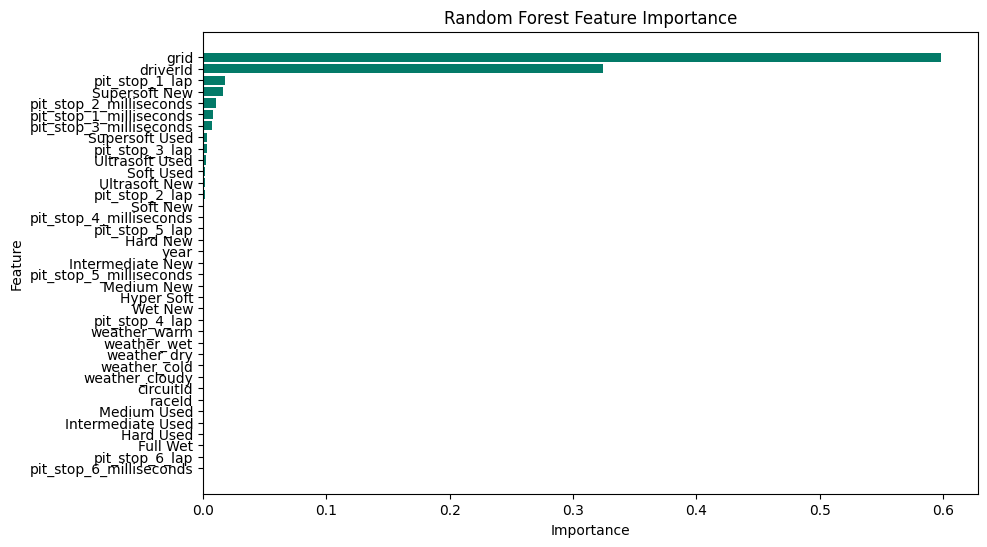

In [ ]:
# Most important features

# Set the color to #037A68
bar_color = '#037A68'

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_forest['Feature'], importance_df_forest['Importance'], color=bar_color)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


other year

In [ ]:


# Columns for which we want to calculate the median
columns_to_fit_median = ['Full Wet', 'Hard New', 'Hard Used', 'Hyper Soft', 'Intermediate New', 'Intermediate Used',
                         'Medium New', 'Medium Used', 'Soft New', 'Soft Used', 'Supersoft New', 'Supersoft Used',
                         'Ultrasoft New', 'Ultrasoft Used', 'Wet New', 'pit_stop_1_lap', 'pit_stop_1_milliseconds',
                         'pit_stop_2_lap', 'pit_stop_2_milliseconds', 'pit_stop_3_lap', 'pit_stop_3_milliseconds',
                         'pit_stop_4_lap', 'pit_stop_4_milliseconds', 'pit_stop_5_lap', 'pit_stop_5_milliseconds',
                         'pit_stop_6_lap', 'pit_stop_6_milliseconds']

# Step 1: Data Preprocessing
X = balanced_df.drop(columns=['Class'])  # Features
y = balanced_df['Class']  # Target variable

# Step 2: Data Splitting
# Define a condition to split the data
train_condition = X['year'] < 2022  # Train until 2018 (excluding 2019)

# Split the data based on the condition
X_train = X[train_condition]
y_train = y[train_condition]

# Test data for the year 2019
X_test = X[X['year'] == 2022]
y_test = y[X['year'] == 2022]

# Step 3: Calculate the median values for each 'circuitId' group using X_train
median_values = X_train.groupby('circuitId')[columns_to_fit_median].transform('median')

# Step 4: Impute missing values in X_test with the corresponding median values
imputer = SimpleImputer(strategy='median')
X_test_imputed = X_test.copy()
X_test_imputed[columns_to_fit_median] = imputer.fit_transform(X_test[columns_to_fit_median])

# Step 5: Create the Random Forest classifier
# You can specify the number of estimators (trees) in the forest using the n_estimators parameter.
# You can adjust other hyperparameters as needed.
forest_model = RandomForestClassifier(random_state=42, n_estimators=100, ccp_alpha=0.03)  # Adjust hyperparameters as needed

# Step 6: Train the model on the training data
forest_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred_forest = forest_model.predict(X_test_imputed)

# Step 8: Evaluate the Random Forest model's performance
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f'Random Forest Accuracy: {accuracy_forest}')
print(classification_report(y_test, y_pred_forest))

# Optional: Visualize feature importances for the Random Forest
feature_importances_forest = forest_model.feature_importances_
importance_df_forest = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_forest})
importance_df_forest = importance_df_forest.sort_values(by='Importance', ascending=False)
print(importance_df_forest)



Random Forest Accuracy: 0.7321937321937322
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       219
           1       0.71      0.49      0.58       132

    accuracy                           0.73       351
   macro avg       0.72      0.68      0.69       351
weighted avg       0.73      0.73      0.72       351

                    Feature  Importance
2                      grid    0.636354
0                  driverId    0.296106
14            Supersoft New    0.013522
28  pit_stop_2_milliseconds    0.009289
13                Soft Used    0.008819
26  pit_stop_1_milliseconds    0.007316
30  pit_stop_3_milliseconds    0.006377
25           pit_stop_1_lap    0.004323
17           Ultrasoft Used    0.002417
5                  Hard New    0.002060
29           pit_stop_3_lap    0.002050
15           Supersoft Used    0.001637
11              Medium Used    0.001580
12                 Soft New    0.001540
3                      year   

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[73  7]
 [30 82]]


                    Feature  Importance
2                      grid    0.903486
8          Intermediate New    0.040704
32  pit_stop_4_milliseconds    0.028127
26  pit_stop_1_milliseconds    0.027683
0                  driverId    0.000000
28  pit_stop_2_milliseconds    0.000000
22              weather_dry    0.000000
23             weather_warm    0.000000
24              weather_wet    0.000000
25           pit_stop_1_lap    0.000000
27           pit_stop_2_lap    0.000000
30  pit_stop_3_milliseconds    0.000000
29           pit_stop_3_lap    0.000000
20           weather_cloudy    0.000000
31           pit_stop_4_lap    0.000000
33           pit_stop_5_lap    0.000000
34  pit_stop_5_milliseconds    0.000000
35           pit_stop_6_lap    0.000000
21             weather_cold    0.000000
18                  Wet New    0.000000
19                circuitId    0.000000
10               Medium New    0.000000
3                      year    0.000000
4                  Full Wet    0.000000


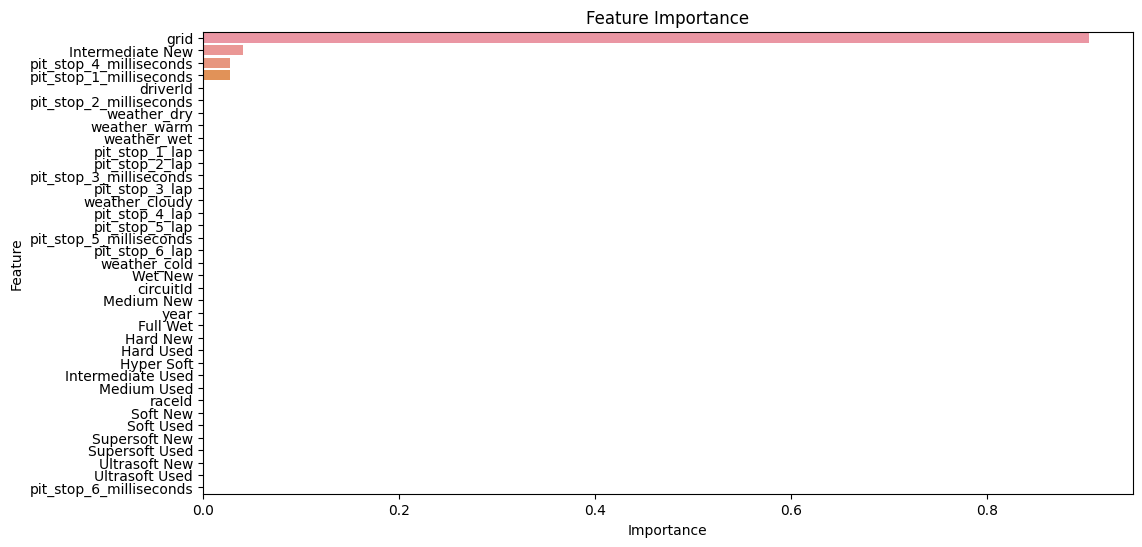

In [ ]:
# Calculate feature importances
feature_importances = tree_model.feature_importances_

# Create a DataFrame to display the feature importances with corresponding column names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(importance_df)

# You can also create a bar plot to visualize the feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
